# Property of FastMap on Graph

This experiments note used to analyze the property of FastMap algorithm on (directed) graphs. We will try to figure which structure can be handled by FastMap well (approximate the target value more accurate), and on the other side, which structures will be disasters for FastMap algorithm.

See [here](https://github.com/ZhiruiFeng/playground/blob/master/FastMap/FastMap.ipynb) for some backgrounds about fastmap.

1. FastMap tender to overestimate or underestimate the target value?
    - For different norms: $L_1$ and $L_2$
    - For different targets: `max` and `average` in directed graph, `distance` in undirected graph.
    - It's relationship with the dimention of embedding in the target space.
2. Is there a theoretical bound on the traditional data mining version of FastMap?

In [5]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import heuristic.fastmap.utils as utils
from heuristic.fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff, difastmap_max 
import heuristic.fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
import numpy as np
import math
from random import sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Density: 0.007007007007007007


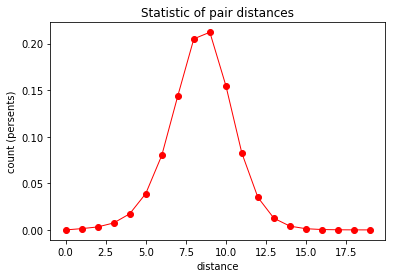

In [6]:
n = 1000
p = 0.007
low = 1
high = 5

G, density = utils.generate_random_digraph(n, p, low, high)
utils.distance_info(G)

In [9]:
def meta_distortion_analyse(i):
    global G, embedding, subset, alg, variant, threshold
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = nx.single_source_dijkstra_path_length(G, node_1)
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    for j in range(i+1, len(subset)):
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        if variant == 'undirected':
            target_dis = distance
        elif variant == 'average':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = (float(distance) + float(distance_reverse))/2
        elif variant == 'max':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = max(float(distance), float(distance_reverse))
        elif variant == 'diff':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = abs(float(distance) - float(distance_reverse))/2
        if alg == 'L1':
            embdis = np.sum(np.abs(emb_1-emb_2))
        elif alg == 'L2':
            embdis = math.sqrt(np.dot(emb_1-emb_2, emb_1-emb_2))
        if embdis > target_dis + threshold:
            larger += 1
        elif embdis < target_dis - threshold:
            smaller += 1
        else:
            equal += 1
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d, larger, equal, smaller]

def distortion_analyse_mp(G, embedding, subset, alg, variant, threshold):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_analyse, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d, larger, equal, smaller = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)/2
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base

    return float(sigma)/ave_d, larger, equal, smaller

In [10]:
n = 1000
p = 0.007
low = 1
high = 2

G, density = utils.generate_random_digraph(n, p, low, high)
klist = [8, 12, 16, 18, 20, 22, 24, 26, 30]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

Density: 0.007065065065065065
#########Test for K:8
Pool size: 8
0.503813839628916
(195.0, 12.0, 19693.0)
#########Test for K:12
Pool size: 8
0.359256362789864
(1059.0, 36.0, 18805.0)
#########Test for K:16
Pool size: 8
0.26829770568592265
(3657.0, 102.0, 16141.0)
#########Test for K:18
Pool size: 8
0.23520076329546727
(5567.0, 130.0, 14203.0)
#########Test for K:20
Pool size: 8
0.2043937619302858
(7284.0, 156.0, 12460.0)
#########Test for K:22
Pool size: 8
0.20311150569588202
(9328.0, 173.0, 10399.0)
#########Test for K:24
Pool size: 8
0.21026114959049005
(11929.0, 147.0, 7824.0)
#########Test for K:26
Pool size: 8
0.26339381292622216
(15249.0, 119.0, 4532.0)
#########Test for K:30
Pool size: 8
0.4206802395477541
(18273.0, 51.0, 1576.0)


In [11]:
n = 1000
p = 0.007
low = 1
high = 2

G, density = utils.generate_random_digraph(n, p, low, high)
klist = [8, 12, 16, 18, 20, 22, 24, 26, 30]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

Density: 0.007021021021021021
#########Test for K:8
Pool size: 8
0.44807650787995723
(443.0, 23.0, 19434.0)
#########Test for K:12
Pool size: 8
0.33650765052709625
(1680.0, 55.0, 18165.0)
#########Test for K:16
Pool size: 8
0.24260995335372337
(5624.0, 114.0, 14162.0)
#########Test for K:18
Pool size: 8
0.22365465695969988
(8531.0, 126.0, 11243.0)
#########Test for K:20
Pool size: 8
0.2106758972668568
(9404.0, 166.0, 10330.0)
#########Test for K:22
Pool size: 8
0.25577190545948403
(12865.0, 126.0, 6909.0)
#########Test for K:24
Pool size: 8
0.23892281739831683
(12924.0, 146.0, 6830.0)
#########Test for K:26
Pool size: 8
0.2752457629698379
(15512.0, 114.0, 4274.0)
#########Test for K:30
Pool size: 8
0.4303653400445084
(18378.0, 40.0, 1482.0)


In [13]:
n = 1000
p = 0.007
low = 1
high = 2

G, density = utils.generate_random_digraph(n, p, low, high)
klist = [4, 5, 6, 7, 8, 9, 10, 11, 12]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

Density: 0.006886886886886887
#########Test for K:4
Pool size: 8
0.6117929646341713
(200.0, 126.0, 19574.0)
#########Test for K:5
Pool size: 8
0.5084595183154385
(711.0, 316.0, 18873.0)
#########Test for K:6
Pool size: 8
0.44068857890328883
(1465.0, 534.0, 17901.0)
#########Test for K:7
Pool size: 8
0.351173907192083
(4147.0, 997.0, 14756.0)
#########Test for K:8
Pool size: 8
0.30331784063403167
(6411.0, 1228.0, 12261.0)
#########Test for K:9
Pool size: 8
0.31430605927134136
(9769.0, 1272.0, 8859.0)
#########Test for K:10
Pool size: 8
0.34985844704247115
(12189.0, 1129.0, 6582.0)
#########Test for K:11
Pool size: 8
0.47848416562544094
(14888.0, 848.0, 4164.0)
#########Test for K:12
Pool size: 8
0.5274895218967248
(16390.0, 717.0, 2793.0)


In [14]:
n = 1000
p = 0.007
low = 1
high = 2

G, density = utils.generate_random_digraph(n, p, low, high)
klist = [6, 7, 8, 9, 10, 11]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

Density: 0.00709009009009009
#########Test for K:6
Pool size: 8
0.4429714688913713
(1741.0, 1035.0, 17124.0)
#########Test for K:7
Pool size: 8
0.33915149793644384
(5314.0, 1981.0, 12605.0)
#########Test for K:8
Pool size: 8
0.3289264306677068
(7588.0, 2087.0, 10225.0)
#########Test for K:9
Pool size: 8
0.34358321887060905
(9915.0, 2105.0, 7880.0)
#########Test for K:10
Pool size: 8
0.37780561957144426
(11794.0, 1959.0, 6147.0)
#########Test for K:11
Pool size: 8
0.49254116208488086
(14766.0, 1551.0, 3583.0)


In [16]:
n = 1000
p = 0.007
low = 1
high = 2

G, density = utils.generate_random_digraph(n, p, low, high)

print("!!!!!!!!! L1 Norm")
klist = [2, 3, 4, 5]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_diff(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'diff'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])
    
print("!!!!!!!!! L2 Norm")
klist = [4, 6, 8, 10, 12]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_diff(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'diff'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

Density: 0.0069899899899899896
!!!!!!!!! L1 Norm
#########Test for K:2
Pool size: 8
1.1122207506411343
(9824.0, 3219.0, 6857.0)
#########Test for K:3
Pool size: 8
1.691143222054482
(14666.0, 1944.0, 3290.0)
#########Test for K:4
Pool size: 8
2.271535210266125
(17238.0, 1125.0, 1537.0)
#########Test for K:5
Pool size: 8
3.19382112503717
(18779.0, 486.0, 635.0)
!!!!!!!!! L2 Norm
#########Test for K:4
Pool size: 8
1.0122934834860489
(9922.0, 347.0, 9631.0)
#########Test for K:6
Pool size: 8
0.9871059501624397
(11209.0, 318.0, 8373.0)
#########Test for K:8
Pool size: 8
1.2401126582497957
(15172.0, 224.0, 4504.0)
#########Test for K:10
Pool size: 8
1.2428054802630228
(15309.0, 216.0, 4375.0)
#########Test for K:12
Pool size: 8
1.3871106172478078
(16417.0, 165.0, 3318.0)


**Conclusion on directed graph**

- As for dimention $K$


1. For both $L_1$, $L_2$ and `average`, `max`: the distortion first decrease and later increase, and when it reaches the best one, the comparsion show nearly half of the prediction are larger than real distances while the other half are smaller.
    - The reason is the algorithm here doesn't make sure the **information** decrease on the graph, which is different from the $L_1$ version of undirected graph. Thus the bigger the dimension, the begger the predicted distance.
    - **Attention**: we need to prove this algorithm cannot end by $\epsilon$
2. $L_1$ (8) can reach its best distortion with **smaller** $K$ than $L_2$ (20), but $L_2$ get the better distortion for whole.
    - **Attention**: we need to understand the reason here by theoretically compare the features of $L_1$ and $L_2$ algorithms
3. Both of $L_1$, $L_2$ requires the target to be symmetry and obey the triangular inequality, which means `diff` is not promissing. So foget about it.


- Other concerns:


1. What's the performance of proximating "$\min\{d_{ij}, d_{ji}\}$"
    - We may need different $K_1$, $K_2$ for `average`, `max`, and we should choose each of them the best one, otherwise the distortion can only become bigger from the whole view.
    - This is the same for choosing $L_2$ norm rather than $L_1$, unless there is some property under the algorithms.
    - The result have been tested at [RandomGraph](https://github.com/ZhiruiFeng/explorer/blob/master/test/RandomGraph.ipynb)
2. The performance is not stable when choosing different pivots.
    - Choosing the farthest pair of nodes is the idea carried by Data Mining FastMap, which is because it can be the best way to differential nodes after one dimension reduction.
    - However, is this still works good when we have a general graph, where the space is more complex?
    - **Attention**: We need to have a discussion on how to choose pivots.
3. Have a test on undirected graph, which can help knowing what's the ideal embedding. **Experiments**